# Load Data and Word-Embedding Models

In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train_data_v2.json', 'r'))
val_data = json.load(open('NER_val_data_v2.json', 'r'))
test_data = json.load(open('NER_test_data_v2.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# Vanilla RNN Implementation

In [3]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.rnn = nn.RNN(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device=x.device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out)
        return out

# Training and Validation Code

In [4]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"]
                pattern = r'[ ]+'
                text = re.split(pattern, text)
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Fine-Tuning on Validation Data

In [5]:
def fine_tune(model, embedding_model, val_data,  criterion, optimizer, device='cuda', epochs=3):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        tuning_loss = 0
        actual = []
        predicted = []
        for _, data in val_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            actual.extend(targets.tolist())     
            tuning_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tuning_loss = tuning_loss / len(val_data)
        accuracy = accuracy_score(actual, predicted)
        f1 = f1_score(actual, predicted, average="macro")
        print(f"FineTuning: Loss: {tuning_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

# Testing Code

In [6]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [7]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [8]:
input_size = 300  # Embedding size
hidden_size = 128  # Hidden size of the RNN
output_size = 27   # BIO encoding

# For Word2Vec Embeddings

In [9]:
rnn_word2vec_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_word2vec_model.parameters(), lr=0.001)

In [10]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            rnn_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/15
Training: Loss: 0.5178, Accuracy: 0.8768, F1: 0.2685
Validation: Loss: 0.4507, Accuracy: 0.8842, F1: 0.3175
Epoch 2/15
Training: Loss: 0.4075, Accuracy: 0.8964, F1: 0.3723
Validation: Loss: 0.4088, Accuracy: 0.8959, F1: 0.3654
Epoch 3/15
Training: Loss: 0.3780, Accuracy: 0.9025, F1: 0.4088
Validation: Loss: 0.3898, Accuracy: 0.8978, F1: 0.3875
Epoch 4/15
Training: Loss: 0.3639, Accuracy: 0.9050, F1: 0.4279
Validation: Loss: 0.3753, Accuracy: 0.9014, F1: 0.4116
Epoch 5/15
Training: Loss: 0.3498, Accuracy: 0.9080, F1: 0.4459
Validation: Loss: 0.3753, Accuracy: 0.9033, F1: 0.4114
Epoch 6/15
Training: Loss: 0.3432, Accuracy: 0.9094, F1: 0.4571
Validation: Loss: 0.3613, Accuracy: 0.9080, F1: 0.4271
Epoch 7/15
Training: Loss: 0.3325, Accuracy: 0.9119, F1: 0.4734
Validation: Loss: 0.3704, Accuracy: 0.9069, F1: 0.4147
Epoch 8/15
Training: Loss: 0.3338, Accuracy: 0.9116, F1: 0.4744
Validation: Loss: 0.3529, Accuracy: 0.9087, F1: 0.4460
Epoch 9/15
Training: Loss: 0.3309, Accuracy: 0.9

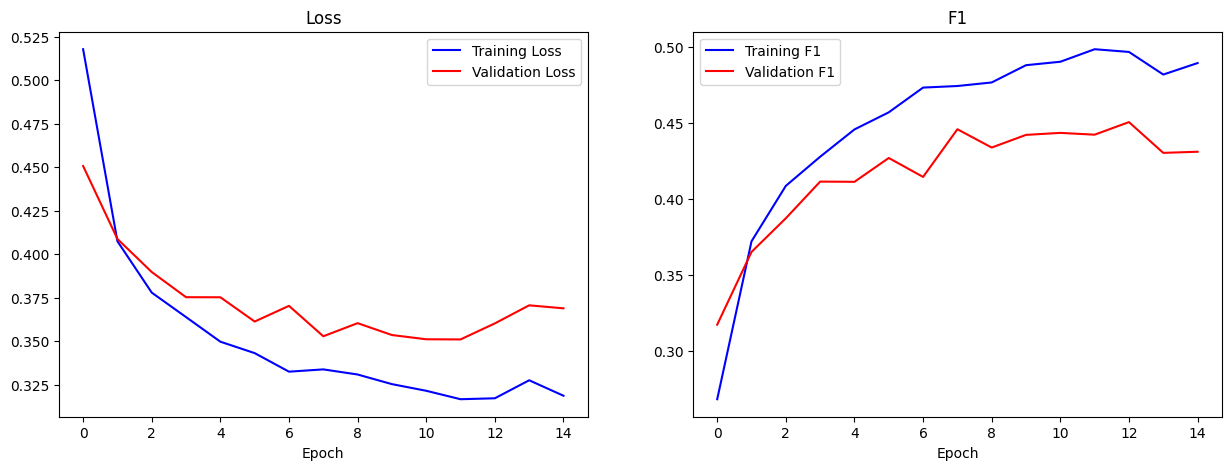

In [11]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [12]:
# fine_tune(rnn_word2vec_model, word2vec, val_data, criterion, optimizer, device='cuda', epochs=2)

In [13]:
torch.save(rnn_word2vec_model, "t1_model1_word2vec.pt")

In [14]:
test_accuracy, test_f1 = test("t1_model1_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.0520786224701757, 1: 0.045321637426900575, 2: 0.08726752503576539, 3: 0.01564537157757497, 4: 0.022748375116063136, 5: 0.048220436280137766, 6: 0.07547169811320754, 7: 0.065, 8: 0.07871198568872988, 9: 0.22138228941684662, 10: 0.1764705882352941, 11: 0.11675367821547224, 12: 0.06197816313423251, 13: 0.025806451612903226, 14: 0.028444444444444446, 15: 0.056115384615384616, 16: 0.17575757575757575, 17: 0.16666666666666666, 18: 0.10666666666666666, 19: 0.07272727272727272, 20: 0.04769874476987448, 21: 0.0, 22: 0.0, 23: 0.20348837209302326, 24: 0.0, 25: 0.0, 26: 0.022408963585434174}
Labelwise Accuracy Scores:
{0: 0.9792061179898034, 1: 0.256198347107438, 2: 0.3546511627906977, 3: 0.11320754716981132, 4: 0.15806451612903225, 5: 0.45652173913043476, 6: 0.358974358974359, 7: 0.35135135135135137, 8: 0.4595300261096606, 9: 0.7945736434108527, 10: 0.7894736842105263, 11: 0.6910112359550562, 12: 0.5920245398773006, 13: 0.06896551724137931, 14: 0.2711864406779661, 15: 0

# For GloVe Embeddings

In [25]:
rnn_glove_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_glove_model.parameters(), lr=0.001)
optimizer = optim.SGD(rnn_glove_model.parameters(), lr=0.1)

In [26]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            rnn_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10


Training: Loss: 0.6566, Accuracy: 0.8447, F1: 0.1302
Validation: Loss: 0.6140, Accuracy: 0.8427, F1: 0.1949
Epoch 2/10
Training: Loss: 0.5825, Accuracy: 0.8588, F1: 0.1930
Validation: Loss: 0.5622, Accuracy: 0.8571, F1: 0.2226
Epoch 3/10
Training: Loss: 0.5941, Accuracy: 0.8560, F1: 0.1915
Validation: Loss: 0.6376, Accuracy: 0.8472, F1: 0.2103
Epoch 4/10
Training: Loss: 0.5789, Accuracy: 0.8596, F1: 0.2067
Validation: Loss: 0.5635, Accuracy: 0.8626, F1: 0.2398
Epoch 5/10
Training: Loss: 0.5724, Accuracy: 0.8616, F1: 0.2155
Validation: Loss: 0.5906, Accuracy: 0.8552, F1: 0.2293
Epoch 6/10
Training: Loss: 0.5778, Accuracy: 0.8604, F1: 0.2148
Validation: Loss: 0.5933, Accuracy: 0.8533, F1: 0.2393
Epoch 7/10
Training: Loss: 0.5784, Accuracy: 0.8599, F1: 0.2140
Validation: Loss: 0.5955, Accuracy: 0.8539, F1: 0.2218
Epoch 8/10
Training: Loss: 0.5713, Accuracy: 0.8621, F1: 0.2172
Validation: Loss: 0.5843, Accuracy: 0.8549, F1: 0.2344
Epoch 9/10
Training: Loss: 0.5726, Accuracy: 0.8630, F1: 0.

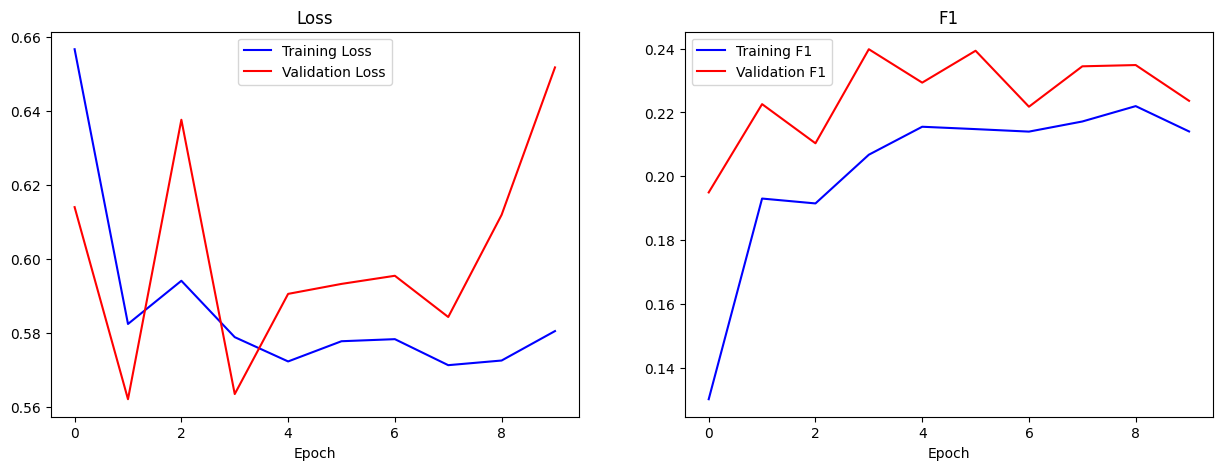

In [27]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [28]:
torch.save(rnn_glove_model, "t1_model1_glove.pt")

In [29]:
test_accuracy, test_f1 = test("t1_model1_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.06434139202422004, 1: 0.02335766423357664, 2: 0.06222707423580786, 3: 0.0, 4: 0.0, 5: 0.006259780907668233, 6: 0.005076142131979696, 7: 0.0851851851851852, 8: 0.019093078758949878, 9: 0.0762589928057554, 10: 0.06553846153846155, 11: 0.03186274509803922, 12: 0.0596393897364771, 13: 0.0, 14: 0.003333333333333333, 15: 0.0946470588235294, 16: 0.14646464646464646, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.025889967637540454, 21: 0.0, 22: 0.0, 23: 0.12106537530266345, 24: 0.0, 25: 0.0, 26: 0.0}
Labelwise Accuracy Scores:
{0: 0.9325928623452294, 1: 0.1322314049586777, 2: 0.3313953488372093, 3: 0.0, 4: 0.0, 5: 0.028985507246376812, 6: 0.010256410256410256, 7: 0.6216216216216216, 8: 0.09399477806788512, 9: 0.6162790697674418, 10: 0.4874141876430206, 11: 0.14606741573033707, 12: 0.26380368098159507, 13: 0.0, 14: 0.01694915254237288, 15: 0.8983807928531546, 16: 0.7837837837837838, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.13186813186813187, 21: 0.0, 22: 0.0, 23: 0.7352941176470589, 24: 0

# For FastText Embeddings

In [30]:
rnn_fasttext_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_fasttext_model.parameters(), lr=0.001)

In [31]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        rnn_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10


Training: Loss: 0.5050, Accuracy: 0.8782, F1: 0.2702
Validation: Loss: 0.4015, Accuracy: 0.8946, F1: 0.3499
Epoch 2/10
Training: Loss: 0.3721, Accuracy: 0.9028, F1: 0.3953
Validation: Loss: 0.3535, Accuracy: 0.9081, F1: 0.4255
Epoch 3/10
Training: Loss: 0.3420, Accuracy: 0.9103, F1: 0.4421
Validation: Loss: 0.3438, Accuracy: 0.9113, F1: 0.4389
Epoch 4/10
Training: Loss: 0.3263, Accuracy: 0.9139, F1: 0.4646
Validation: Loss: 0.3398, Accuracy: 0.9111, F1: 0.4518
Epoch 5/10
Training: Loss: 0.3128, Accuracy: 0.9168, F1: 0.4830
Validation: Loss: 0.3356, Accuracy: 0.9124, F1: 0.4411
Epoch 6/10
Training: Loss: 0.3045, Accuracy: 0.9191, F1: 0.4963
Validation: Loss: 0.3276, Accuracy: 0.9153, F1: 0.4603
Epoch 7/10
Training: Loss: 0.2960, Accuracy: 0.9198, F1: 0.5007
Validation: Loss: 0.3164, Accuracy: 0.9169, F1: 0.4668
Epoch 8/10
Training: Loss: 0.2944, Accuracy: 0.9208, F1: 0.5096
Validation: Loss: 0.3177, Accuracy: 0.9179, F1: 0.4701
Epoch 9/10
Training: Loss: 0.2933, Accuracy: 0.9209, F1: 0.

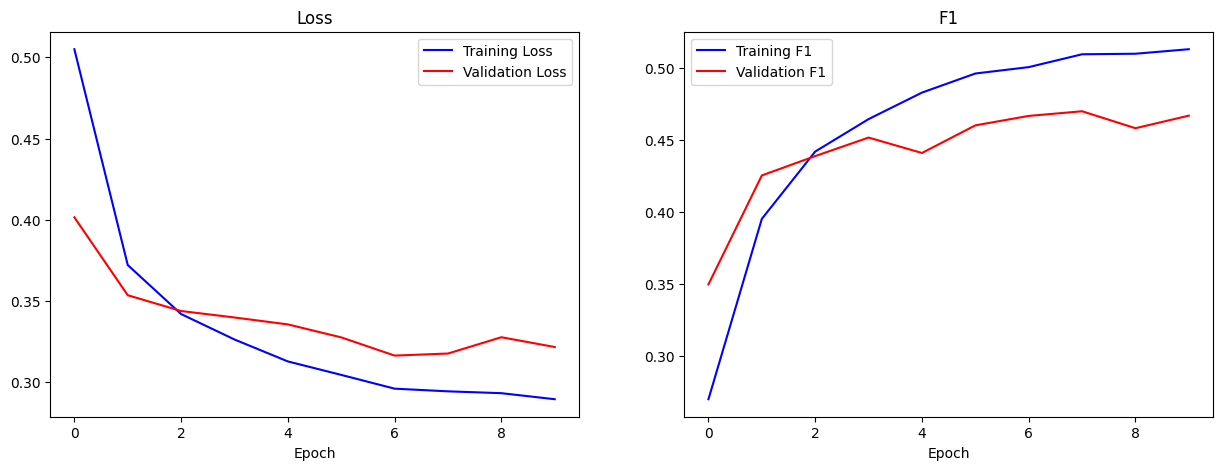

In [32]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [33]:
torch.save(rnn_fasttext_model, "t1_model1_fasttext.pt")

In [34]:
test_accuracy, test_f1 = test("t1_model1_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.04967377758228869, 1: 0.03805175038051751, 2: 0.08864915572232646, 3: 0.02793296089385475, 4: 0.046485260770975055, 5: 0.041810432311751564, 6: 0.06315789473684211, 7: 0.08771929824561404, 8: 0.08853288364249579, 9: 0.22611464968152864, 10: 0.1641025641025641, 11: 0.11786892975011787, 12: 0.06075373619233269, 13: 0.04477611940298507, 14: 0.045267489711934165, 15: 0.06522008065912858, 16: 0.2966666666666667, 17: 0.125, 18: 0.08888888888888889, 19: 0.022988505747126436, 20: 0.06236275801493193, 21: 0.0, 22: 0.0, 23: 0.22131147540983606, 24: 0.1, 25: 0.0, 26: 0.06190476190476191}
Labelwise Accuracy Scores:
{0: 0.9870356882738529, 1: 0.2066115702479339, 2: 0.5494186046511628, 3: 0.12578616352201258, 4: 0.2645161290322581, 5: 0.37318840579710144, 6: 0.46153846153846156, 7: 0.5405405405405406, 8: 0.5483028720626631, 9: 0.8255813953488372, 10: 0.6956521739130435, 11: 0.702247191011236, 12: 0.5736196319018405, 13: 0.15517241379310345, 14: 0.3728813559322034, 15: 0.73